# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

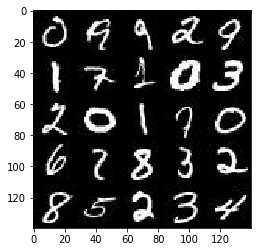

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')


### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

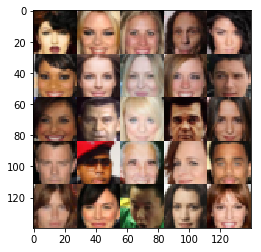

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels));
    z_input = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32, name='learning_rate')
    return real_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [27]:
def leaky_relu(x, alpha=0.1, name='leaky_relu'):
    '''
    x: Tensor
    alpha: leaky multiplier
    name: tensor name
    Leaky relu implementation. 
    
    Returns tensor applying leaky relu on input tensor. 
    '''
    return tf.maximum(x, x * alpha, name=name)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [30]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # First convolution. 
        # We are reducing image width & height by 2 and depth is 16.
        # Image size is 28x28x(1 - MNIST, 3 - celeb)
        layer = tf.layers.conv2d(images, 
                                 64, 
                                 3, 
                                 strides=2, 
                                 padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer = leaky_relu(layer)
        layer = tf.layers.dropout(layer, rate=0.9)
        # 14x14x64
        
        # Second convolution 
        layer = tf.layers.conv2d(layer, 
                                 128, 
                                 3, 
                                 strides=2, 
                                 padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = leaky_relu(layer)
        layer = tf.layers.dropout(layer, rate=0.9)
        # 7x7x128

        # Third convolution 
        layer = tf.layers.conv2d(layer, 
                                 256, 
                                 3, 
                                 strides=2,
                                 padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = leaky_relu(layer)
        layer = tf.layers.dropout(layer, rate=0.9)
        # 4x4x256

        flat = tf.reshape(layer, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        output = tf.nn.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [31]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        layer = tf.layers.dense(z, 7*7*1024)
        layer = tf.reshape(layer, (-1, 7, 7, 1024))
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.nn.relu(layer)
        # 7x7x1024
        
        layer = tf.layers.conv2d_transpose(layer, 512, 3, strides=2, padding='same')
        layer = tf.layers.batch_normalization(layer, training=is_train)
        r1 = tf.nn.relu(layer)
        #14x14x512
                
        layer = tf.layers.conv2d_transpose(layer, 256, 3, strides=2, padding='same')
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.nn.relu(layer)
        #28x28x256

        layer = tf.layers.conv2d_transpose(layer, out_channel_dim, 3, strides=2, padding='same')
        # 52x52xout_dim
        
        layer = tf.image.resize_images(layer, size=(28, 28))
        # 28x28xoutput_dim 
        
        output = tf.nn.tanh(layer)

    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [32]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_real_model, d_real_logits = discriminator(input_real, reuse=False)
    d_fake_model, d_fake_logits = discriminator(g_model, reuse=True)
    
    smooth = 0.1
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, \
                                                          labels=tf.ones_like(d_real_model) * (1 - smooth)))
    
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, \
                                                            labels=tf.zeros_like(d_fake_model)))
    d_loss = d_real_loss + d_fake_loss
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_model)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [33]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [34]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print("z_dim=", z_dim)
    print("data_shape=", data_shape)
    print("data_image_mode=", data_image_mode)
    
    out_channel_dim = 3 if data_image_mode == 'RGB' else 1
    real_input, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    batch = 0;
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch+=1

                # Batch images value is in range from -0.5 to 0.5
                # But our discriminator expects values from -1 to 1 s
                # So scale the images.  
                batch_images = 2 * batch_images
                batch_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                # print("BatchSize=", batch_images.shape)
                sess.run(d_opt, feed_dict = {
                    lr : learning_rate,
                    real_input : batch_images, 
                    z_input : batch_z
                })
                
                sess.run(g_opt, feed_dict = {
                    lr :learning_rate,
                    z_input : batch_z,
                })
                
                if batch % 10 == 0:
                    # run losses. 
                    train_loss_d = sess.run(d_loss, feed_dict = { real_input : batch_images, z_input : batch_z})
                    train_loss_g = sess.run(g_loss, feed_dict =  { z_input : batch_z})
                    print("Epoch {}/{}... Step {}...".format(epoch_i+1, epochs, batch),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                    
                if batch % 100 == 0:
                    print("Generating sample outputs")
                    show_generator_output(sess, 10, z_input, out_channel_dim, data_image_mode)
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [18]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
for image in mnist_dataset.get_batches(1):
    # print(image * 2)
    break


z_dim= 100
data_shape= (60000, 28, 28, 1)
data_image_mode= L
Epoch 1/2... Step 10... Discriminator Loss: 0.4209... Generator Loss: 11.2643
Epoch 1/2... Step 20... Discriminator Loss: 0.5872... Generator Loss: 11.3617
Epoch 1/2... Step 30... Discriminator Loss: 1.6948... Generator Loss: 25.9110
Epoch 1/2... Step 40... Discriminator Loss: 3.6510... Generator Loss: 0.1338
Epoch 1/2... Step 50... Discriminator Loss: 2.5182... Generator Loss: 3.1965
Epoch 1/2... Step 60... Discriminator Loss: 2.2454... Generator Loss: 4.5328
Epoch 1/2... Step 70... Discriminator Loss: 2.4335... Generator Loss: 3.6823
Epoch 1/2... Step 80... Discriminator Loss: 2.1150... Generator Loss: 4.7336
Epoch 1/2... Step 90... Discriminator Loss: 1.7516... Generator Loss: 2.2483
Epoch 1/2... Step 100... Discriminator Loss: 1.8645... Generator Loss: 3.4025
Generating sample outputs


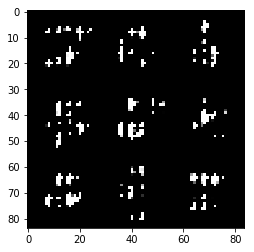

Epoch 1/2... Step 110... Discriminator Loss: 1.2340... Generator Loss: 1.8717
Epoch 1/2... Step 120... Discriminator Loss: 1.5312... Generator Loss: 2.5425
Epoch 1/2... Step 130... Discriminator Loss: 1.9633... Generator Loss: 2.6014
Epoch 1/2... Step 140... Discriminator Loss: 2.6109... Generator Loss: 0.1557
Epoch 1/2... Step 150... Discriminator Loss: 1.1828... Generator Loss: 0.7465
Epoch 1/2... Step 160... Discriminator Loss: 1.2176... Generator Loss: 0.6709
Epoch 1/2... Step 170... Discriminator Loss: 1.3340... Generator Loss: 0.6232
Epoch 1/2... Step 180... Discriminator Loss: 1.4053... Generator Loss: 0.4877
Epoch 1/2... Step 190... Discriminator Loss: 0.8756... Generator Loss: 1.0233
Epoch 1/2... Step 200... Discriminator Loss: 0.9090... Generator Loss: 1.5289
Generating sample outputs


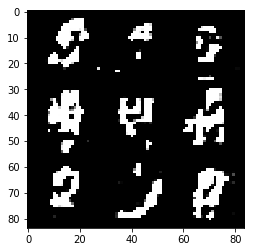

Epoch 1/2... Step 210... Discriminator Loss: 0.7302... Generator Loss: 1.4937
Epoch 1/2... Step 220... Discriminator Loss: 1.0615... Generator Loss: 1.2436
Epoch 1/2... Step 230... Discriminator Loss: 1.2497... Generator Loss: 1.6694
Epoch 1/2... Step 240... Discriminator Loss: 1.0196... Generator Loss: 2.4225
Epoch 1/2... Step 250... Discriminator Loss: 1.1402... Generator Loss: 1.6397
Epoch 1/2... Step 260... Discriminator Loss: 1.1885... Generator Loss: 1.5438
Epoch 1/2... Step 270... Discriminator Loss: 1.3153... Generator Loss: 0.6003
Epoch 1/2... Step 280... Discriminator Loss: 1.0571... Generator Loss: 0.8967
Epoch 1/2... Step 290... Discriminator Loss: 0.7029... Generator Loss: 1.5092
Epoch 1/2... Step 300... Discriminator Loss: 1.9057... Generator Loss: 0.3111
Generating sample outputs


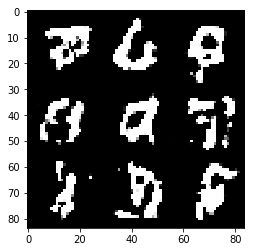

Epoch 1/2... Step 310... Discriminator Loss: 1.9710... Generator Loss: 0.2748
Epoch 1/2... Step 320... Discriminator Loss: 1.3770... Generator Loss: 2.7191
Epoch 1/2... Step 330... Discriminator Loss: 1.1739... Generator Loss: 1.8146
Epoch 1/2... Step 340... Discriminator Loss: 1.2741... Generator Loss: 0.6062
Epoch 1/2... Step 350... Discriminator Loss: 1.8425... Generator Loss: 0.3073
Epoch 1/2... Step 360... Discriminator Loss: 1.2835... Generator Loss: 0.6762
Epoch 1/2... Step 370... Discriminator Loss: 1.2414... Generator Loss: 0.7652
Epoch 1/2... Step 380... Discriminator Loss: 1.2048... Generator Loss: 0.7638
Epoch 1/2... Step 390... Discriminator Loss: 1.2224... Generator Loss: 0.9350
Epoch 1/2... Step 400... Discriminator Loss: 1.2994... Generator Loss: 0.6723
Generating sample outputs


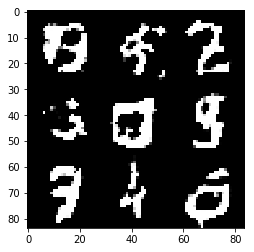

Epoch 1/2... Step 410... Discriminator Loss: 1.1485... Generator Loss: 0.7404
Epoch 1/2... Step 420... Discriminator Loss: 1.2651... Generator Loss: 0.7368
Epoch 1/2... Step 430... Discriminator Loss: 1.4289... Generator Loss: 1.9516
Epoch 1/2... Step 440... Discriminator Loss: 1.1897... Generator Loss: 0.7883
Epoch 1/2... Step 450... Discriminator Loss: 1.3009... Generator Loss: 0.6940
Epoch 1/2... Step 460... Discriminator Loss: 1.7341... Generator Loss: 0.3644
Epoch 1/2... Step 470... Discriminator Loss: 1.4672... Generator Loss: 1.7775
Epoch 1/2... Step 480... Discriminator Loss: 1.2823... Generator Loss: 0.7253
Epoch 1/2... Step 490... Discriminator Loss: 1.7575... Generator Loss: 0.3319
Epoch 1/2... Step 500... Discriminator Loss: 1.4704... Generator Loss: 0.5142
Generating sample outputs


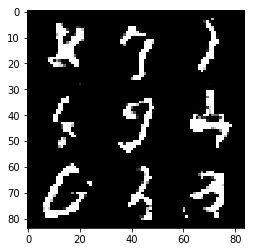

Epoch 1/2... Step 510... Discriminator Loss: 1.1996... Generator Loss: 0.7091
Epoch 1/2... Step 520... Discriminator Loss: 1.2978... Generator Loss: 1.0211
Epoch 1/2... Step 530... Discriminator Loss: 1.6070... Generator Loss: 0.4249
Epoch 1/2... Step 540... Discriminator Loss: 1.6130... Generator Loss: 0.3886
Epoch 1/2... Step 550... Discriminator Loss: 1.2206... Generator Loss: 1.4308
Epoch 1/2... Step 560... Discriminator Loss: 1.2528... Generator Loss: 0.9812
Epoch 1/2... Step 570... Discriminator Loss: 1.5001... Generator Loss: 1.3368
Epoch 1/2... Step 580... Discriminator Loss: 1.3106... Generator Loss: 0.6737
Epoch 1/2... Step 590... Discriminator Loss: 1.3232... Generator Loss: 0.8826
Epoch 1/2... Step 600... Discriminator Loss: 1.2039... Generator Loss: 0.7630
Generating sample outputs


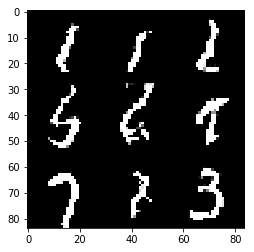

Epoch 1/2... Step 610... Discriminator Loss: 1.5548... Generator Loss: 1.8100
Epoch 1/2... Step 620... Discriminator Loss: 1.2429... Generator Loss: 0.7225
Epoch 1/2... Step 630... Discriminator Loss: 1.3819... Generator Loss: 2.0365
Epoch 1/2... Step 640... Discriminator Loss: 1.1089... Generator Loss: 1.1628
Epoch 1/2... Step 650... Discriminator Loss: 1.4844... Generator Loss: 0.4971
Epoch 1/2... Step 660... Discriminator Loss: 1.0230... Generator Loss: 1.7318
Epoch 1/2... Step 670... Discriminator Loss: 1.1072... Generator Loss: 0.8015
Epoch 1/2... Step 680... Discriminator Loss: 2.3435... Generator Loss: 0.1828
Epoch 1/2... Step 690... Discriminator Loss: 1.3033... Generator Loss: 0.7960
Epoch 1/2... Step 700... Discriminator Loss: 1.3035... Generator Loss: 0.8810
Generating sample outputs


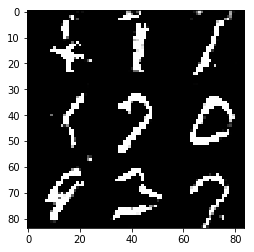

Epoch 1/2... Step 710... Discriminator Loss: 1.1417... Generator Loss: 1.2805
Epoch 1/2... Step 720... Discriminator Loss: 1.1436... Generator Loss: 1.0076
Epoch 1/2... Step 730... Discriminator Loss: 2.4837... Generator Loss: 0.1542
Epoch 1/2... Step 740... Discriminator Loss: 1.4554... Generator Loss: 0.4879
Epoch 1/2... Step 750... Discriminator Loss: 1.4251... Generator Loss: 0.5109
Epoch 1/2... Step 760... Discriminator Loss: 1.3649... Generator Loss: 0.6419
Epoch 1/2... Step 770... Discriminator Loss: 1.7340... Generator Loss: 0.3570
Epoch 1/2... Step 780... Discriminator Loss: 2.1845... Generator Loss: 0.2375
Epoch 1/2... Step 790... Discriminator Loss: 1.3148... Generator Loss: 0.7369
Epoch 1/2... Step 800... Discriminator Loss: 1.1404... Generator Loss: 1.4950
Generating sample outputs


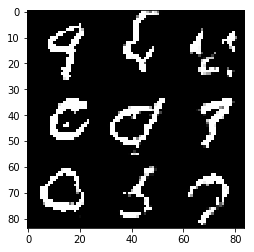

Epoch 1/2... Step 810... Discriminator Loss: 1.2940... Generator Loss: 1.5661
Epoch 1/2... Step 820... Discriminator Loss: 1.4084... Generator Loss: 2.1386
Epoch 1/2... Step 830... Discriminator Loss: 1.6091... Generator Loss: 0.3843
Epoch 1/2... Step 840... Discriminator Loss: 1.2882... Generator Loss: 0.6916
Epoch 1/2... Step 850... Discriminator Loss: 1.7696... Generator Loss: 0.3143
Epoch 1/2... Step 860... Discriminator Loss: 1.5016... Generator Loss: 0.4803
Epoch 1/2... Step 870... Discriminator Loss: 1.4313... Generator Loss: 0.5101
Epoch 1/2... Step 880... Discriminator Loss: 1.7897... Generator Loss: 0.3160
Epoch 1/2... Step 890... Discriminator Loss: 1.7899... Generator Loss: 0.3347
Epoch 1/2... Step 900... Discriminator Loss: 1.5119... Generator Loss: 0.4576
Generating sample outputs


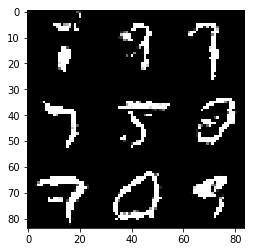

Epoch 1/2... Step 910... Discriminator Loss: 1.5802... Generator Loss: 0.4793
Epoch 1/2... Step 920... Discriminator Loss: 1.4605... Generator Loss: 0.5197
Epoch 1/2... Step 930... Discriminator Loss: 1.5811... Generator Loss: 0.4382
Epoch 2/2... Step 940... Discriminator Loss: 1.6011... Generator Loss: 0.4127
Epoch 2/2... Step 950... Discriminator Loss: 1.4943... Generator Loss: 0.4802
Epoch 2/2... Step 960... Discriminator Loss: 1.5323... Generator Loss: 0.4753
Epoch 2/2... Step 970... Discriminator Loss: 1.3311... Generator Loss: 0.6862
Epoch 2/2... Step 980... Discriminator Loss: 1.2189... Generator Loss: 1.0175
Epoch 2/2... Step 990... Discriminator Loss: 1.2015... Generator Loss: 0.6707
Epoch 2/2... Step 1000... Discriminator Loss: 1.7186... Generator Loss: 0.4040
Generating sample outputs


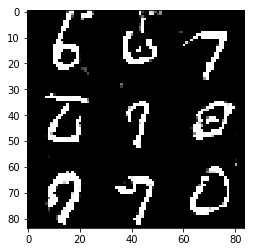

Epoch 2/2... Step 1010... Discriminator Loss: 1.2793... Generator Loss: 0.7427
Epoch 2/2... Step 1020... Discriminator Loss: 1.2540... Generator Loss: 0.7152
Epoch 2/2... Step 1030... Discriminator Loss: 1.2635... Generator Loss: 0.6006
Epoch 2/2... Step 1040... Discriminator Loss: 1.2591... Generator Loss: 0.6335
Epoch 2/2... Step 1050... Discriminator Loss: 0.8677... Generator Loss: 1.5909
Epoch 2/2... Step 1060... Discriminator Loss: 1.2943... Generator Loss: 0.9280
Epoch 2/2... Step 1070... Discriminator Loss: 1.3193... Generator Loss: 1.4015
Epoch 2/2... Step 1080... Discriminator Loss: 1.1995... Generator Loss: 1.2389
Epoch 2/2... Step 1090... Discriminator Loss: 1.2289... Generator Loss: 0.7581
Epoch 2/2... Step 1100... Discriminator Loss: 1.1500... Generator Loss: 0.9136
Generating sample outputs


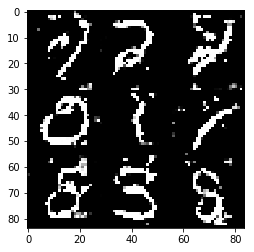

Epoch 2/2... Step 1110... Discriminator Loss: 1.4267... Generator Loss: 1.9338
Epoch 2/2... Step 1120... Discriminator Loss: 1.0457... Generator Loss: 1.2524
Epoch 2/2... Step 1130... Discriminator Loss: 1.1581... Generator Loss: 1.3403
Epoch 2/2... Step 1140... Discriminator Loss: 1.1812... Generator Loss: 1.6646
Epoch 2/2... Step 1150... Discriminator Loss: 1.4782... Generator Loss: 0.5126
Epoch 2/2... Step 1160... Discriminator Loss: 1.5903... Generator Loss: 0.4189
Epoch 2/2... Step 1170... Discriminator Loss: 1.2997... Generator Loss: 1.5120
Epoch 2/2... Step 1180... Discriminator Loss: 1.1708... Generator Loss: 0.7558
Epoch 2/2... Step 1190... Discriminator Loss: 1.8584... Generator Loss: 0.2936
Epoch 2/2... Step 1200... Discriminator Loss: 1.1554... Generator Loss: 0.9192
Generating sample outputs


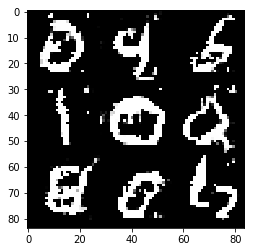

Epoch 2/2... Step 1210... Discriminator Loss: 1.2134... Generator Loss: 1.5717
Epoch 2/2... Step 1220... Discriminator Loss: 1.1172... Generator Loss: 0.8713
Epoch 2/2... Step 1230... Discriminator Loss: 0.9613... Generator Loss: 1.1413
Epoch 2/2... Step 1240... Discriminator Loss: 1.3783... Generator Loss: 0.6743
Epoch 2/2... Step 1250... Discriminator Loss: 1.0247... Generator Loss: 1.1369
Epoch 2/2... Step 1260... Discriminator Loss: 2.2249... Generator Loss: 0.2087
Epoch 2/2... Step 1270... Discriminator Loss: 1.5481... Generator Loss: 0.4643
Epoch 2/2... Step 1280... Discriminator Loss: 1.4148... Generator Loss: 0.6308
Epoch 2/2... Step 1290... Discriminator Loss: 1.4166... Generator Loss: 2.4898
Epoch 2/2... Step 1300... Discriminator Loss: 0.7985... Generator Loss: 2.3022
Generating sample outputs


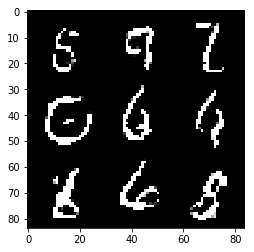

Epoch 2/2... Step 1310... Discriminator Loss: 0.9091... Generator Loss: 1.5530
Epoch 2/2... Step 1320... Discriminator Loss: 1.6497... Generator Loss: 0.4368
Epoch 2/2... Step 1330... Discriminator Loss: 1.3823... Generator Loss: 0.5721
Epoch 2/2... Step 1340... Discriminator Loss: 0.9783... Generator Loss: 0.9838
Epoch 2/2... Step 1350... Discriminator Loss: 1.8320... Generator Loss: 0.3296
Epoch 2/2... Step 1360... Discriminator Loss: 1.0938... Generator Loss: 1.6689
Epoch 2/2... Step 1370... Discriminator Loss: 0.9258... Generator Loss: 1.0572
Epoch 2/2... Step 1380... Discriminator Loss: 0.7863... Generator Loss: 1.3437
Epoch 2/2... Step 1390... Discriminator Loss: 1.2594... Generator Loss: 1.2624
Epoch 2/2... Step 1400... Discriminator Loss: 0.8641... Generator Loss: 1.1737
Generating sample outputs


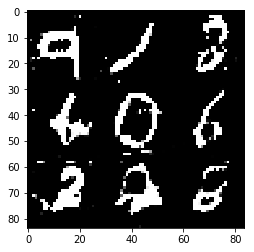

Epoch 2/2... Step 1410... Discriminator Loss: 1.3773... Generator Loss: 0.6620
Epoch 2/2... Step 1420... Discriminator Loss: 1.3793... Generator Loss: 0.6272
Epoch 2/2... Step 1430... Discriminator Loss: 2.1503... Generator Loss: 0.2305
Epoch 2/2... Step 1440... Discriminator Loss: 1.1573... Generator Loss: 0.8277
Epoch 2/2... Step 1450... Discriminator Loss: 1.5831... Generator Loss: 0.4277
Epoch 2/2... Step 1460... Discriminator Loss: 1.1591... Generator Loss: 0.8019
Epoch 2/2... Step 1470... Discriminator Loss: 0.8384... Generator Loss: 2.2913
Epoch 2/2... Step 1480... Discriminator Loss: 0.7681... Generator Loss: 1.4720
Epoch 2/2... Step 1490... Discriminator Loss: 1.3584... Generator Loss: 2.1142
Epoch 2/2... Step 1500... Discriminator Loss: 1.1762... Generator Loss: 2.2169
Generating sample outputs


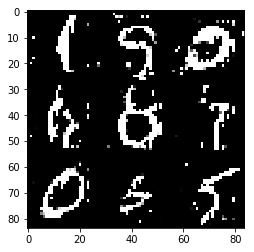

Epoch 2/2... Step 1510... Discriminator Loss: 1.7123... Generator Loss: 0.3977
Epoch 2/2... Step 1520... Discriminator Loss: 1.8532... Generator Loss: 0.3493
Epoch 2/2... Step 1530... Discriminator Loss: 1.9661... Generator Loss: 0.2964
Epoch 2/2... Step 1540... Discriminator Loss: 0.7621... Generator Loss: 1.6825
Epoch 2/2... Step 1550... Discriminator Loss: 0.8949... Generator Loss: 1.1404
Epoch 2/2... Step 1560... Discriminator Loss: 1.9276... Generator Loss: 0.2970
Epoch 2/2... Step 1570... Discriminator Loss: 0.8086... Generator Loss: 1.2349
Epoch 2/2... Step 1580... Discriminator Loss: 1.0070... Generator Loss: 0.9720
Epoch 2/2... Step 1590... Discriminator Loss: 2.5852... Generator Loss: 0.1641
Epoch 2/2... Step 1600... Discriminator Loss: 1.3509... Generator Loss: 0.6350
Generating sample outputs


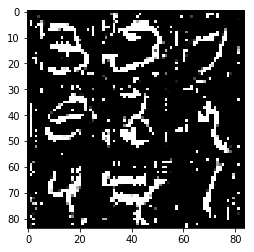

Epoch 2/2... Step 1610... Discriminator Loss: 1.1151... Generator Loss: 0.9237
Epoch 2/2... Step 1620... Discriminator Loss: 1.1430... Generator Loss: 0.8375
Epoch 2/2... Step 1630... Discriminator Loss: 1.3078... Generator Loss: 0.5684
Epoch 2/2... Step 1640... Discriminator Loss: 1.9692... Generator Loss: 2.5205
Epoch 2/2... Step 1650... Discriminator Loss: 1.7061... Generator Loss: 0.3653
Epoch 2/2... Step 1660... Discriminator Loss: 1.8671... Generator Loss: 0.3429
Epoch 2/2... Step 1670... Discriminator Loss: 1.1826... Generator Loss: 0.7057
Epoch 2/2... Step 1680... Discriminator Loss: 1.0856... Generator Loss: 0.9687
Epoch 2/2... Step 1690... Discriminator Loss: 0.9581... Generator Loss: 1.0165
Epoch 2/2... Step 1700... Discriminator Loss: 1.6367... Generator Loss: 0.4303
Generating sample outputs


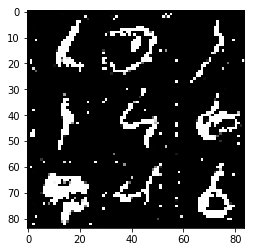

Epoch 2/2... Step 1710... Discriminator Loss: 1.4214... Generator Loss: 0.5585
Epoch 2/2... Step 1720... Discriminator Loss: 1.1457... Generator Loss: 0.7184
Epoch 2/2... Step 1730... Discriminator Loss: 1.6398... Generator Loss: 0.4134
Epoch 2/2... Step 1740... Discriminator Loss: 2.2515... Generator Loss: 3.3608
Epoch 2/2... Step 1750... Discriminator Loss: 1.0698... Generator Loss: 1.0892
Epoch 2/2... Step 1760... Discriminator Loss: 1.2037... Generator Loss: 2.2607
Epoch 2/2... Step 1770... Discriminator Loss: 0.9249... Generator Loss: 1.2495
Epoch 2/2... Step 1780... Discriminator Loss: 1.3711... Generator Loss: 0.5516
Epoch 2/2... Step 1790... Discriminator Loss: 0.8902... Generator Loss: 1.6085
Epoch 2/2... Step 1800... Discriminator Loss: 0.4936... Generator Loss: 2.5573
Generating sample outputs


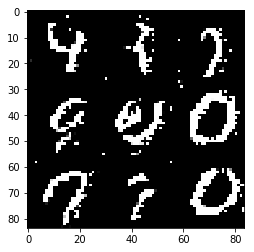

Epoch 2/2... Step 1810... Discriminator Loss: 1.4728... Generator Loss: 2.6104
Epoch 2/2... Step 1820... Discriminator Loss: 1.4265... Generator Loss: 0.4801
Epoch 2/2... Step 1830... Discriminator Loss: 0.7180... Generator Loss: 1.5319
Epoch 2/2... Step 1840... Discriminator Loss: 1.0387... Generator Loss: 0.9426
Epoch 2/2... Step 1850... Discriminator Loss: 1.2800... Generator Loss: 0.7136
Epoch 2/2... Step 1860... Discriminator Loss: 1.3672... Generator Loss: 0.6258
Epoch 2/2... Step 1870... Discriminator Loss: 1.4801... Generator Loss: 3.0387


In [35]:
batch_size = 64
z_dim = 100
learning_rate = 0.005
beta1 = 0.2
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

z_dim= 100
data_shape= (202599, 28, 28, 3)
data_image_mode= RGB
Epoch 1/1... Step 10... Discriminator Loss: 0.4410... Generator Loss: 5.4388
Epoch 1/1... Step 20... Discriminator Loss: 7.3882... Generator Loss: 0.0731
Epoch 1/1... Step 30... Discriminator Loss: 3.1728... Generator Loss: 0.1570
Epoch 1/1... Step 40... Discriminator Loss: 2.3683... Generator Loss: 0.1878
Epoch 1/1... Step 50... Discriminator Loss: 4.0864... Generator Loss: 0.0439
Epoch 1/1... Step 60... Discriminator Loss: 2.2155... Generator Loss: 0.2460
Epoch 1/1... Step 70... Discriminator Loss: 0.4326... Generator Loss: 2.8902
Epoch 1/1... Step 80... Discriminator Loss: 0.6564... Generator Loss: 1.5111
Epoch 1/1... Step 90... Discriminator Loss: 2.0917... Generator Loss: 0.4024
Epoch 1/1... Step 100... Discriminator Loss: 3.5918... Generator Loss: 4.1945
Generating sample outputs


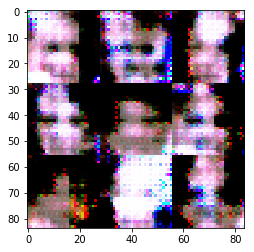

Epoch 1/1... Step 110... Discriminator Loss: 1.2327... Generator Loss: 1.2159
Epoch 1/1... Step 120... Discriminator Loss: 1.3556... Generator Loss: 1.0966
Epoch 1/1... Step 130... Discriminator Loss: 1.2498... Generator Loss: 0.6672
Epoch 1/1... Step 140... Discriminator Loss: 1.7663... Generator Loss: 0.3361
Epoch 1/1... Step 150... Discriminator Loss: 1.2313... Generator Loss: 1.0519
Epoch 1/1... Step 160... Discriminator Loss: 1.2669... Generator Loss: 0.8597
Epoch 1/1... Step 170... Discriminator Loss: 1.1829... Generator Loss: 1.0898
Epoch 1/1... Step 180... Discriminator Loss: 1.2914... Generator Loss: 0.8016
Epoch 1/1... Step 190... Discriminator Loss: 1.3228... Generator Loss: 1.0164
Epoch 1/1... Step 200... Discriminator Loss: 1.2416... Generator Loss: 1.3110
Generating sample outputs


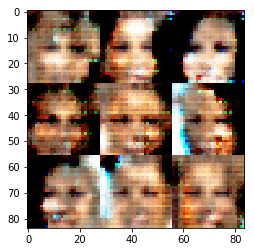

Epoch 1/1... Step 210... Discriminator Loss: 1.5324... Generator Loss: 0.7026
Epoch 1/1... Step 220... Discriminator Loss: 1.5428... Generator Loss: 0.5395
Epoch 1/1... Step 230... Discriminator Loss: 1.3786... Generator Loss: 0.7351
Epoch 1/1... Step 240... Discriminator Loss: 1.2811... Generator Loss: 1.4227
Epoch 1/1... Step 250... Discriminator Loss: 1.3227... Generator Loss: 0.7187
Epoch 1/1... Step 260... Discriminator Loss: 1.2144... Generator Loss: 0.8878
Epoch 1/1... Step 270... Discriminator Loss: 1.3093... Generator Loss: 1.0311
Epoch 1/1... Step 280... Discriminator Loss: 1.3962... Generator Loss: 0.5686
Epoch 1/1... Step 290... Discriminator Loss: 1.3085... Generator Loss: 0.8142
Epoch 1/1... Step 300... Discriminator Loss: 1.4497... Generator Loss: 0.4765
Generating sample outputs


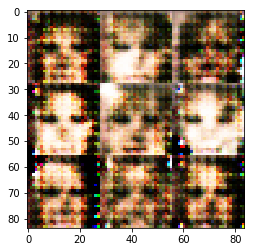

Epoch 1/1... Step 310... Discriminator Loss: 1.3357... Generator Loss: 0.8065
Epoch 1/1... Step 320... Discriminator Loss: 1.2114... Generator Loss: 0.8319
Epoch 1/1... Step 330... Discriminator Loss: 1.4097... Generator Loss: 0.7670
Epoch 1/1... Step 340... Discriminator Loss: 1.0768... Generator Loss: 1.0786
Epoch 1/1... Step 350... Discriminator Loss: 1.3096... Generator Loss: 0.6214
Epoch 1/1... Step 360... Discriminator Loss: 1.2149... Generator Loss: 1.0200
Epoch 1/1... Step 370... Discriminator Loss: 1.2682... Generator Loss: 1.0092
Epoch 1/1... Step 380... Discriminator Loss: 1.2543... Generator Loss: 0.8396
Epoch 1/1... Step 390... Discriminator Loss: 1.0993... Generator Loss: 2.6100
Epoch 1/1... Step 400... Discriminator Loss: 1.2257... Generator Loss: 1.6261
Generating sample outputs


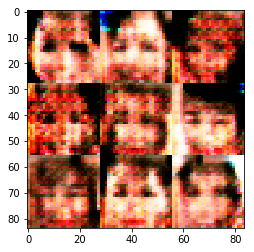

Epoch 1/1... Step 410... Discriminator Loss: 1.2582... Generator Loss: 1.4238
Epoch 1/1... Step 420... Discriminator Loss: 1.0180... Generator Loss: 0.9140
Epoch 1/1... Step 430... Discriminator Loss: 1.7190... Generator Loss: 0.4197
Epoch 1/1... Step 440... Discriminator Loss: 1.2203... Generator Loss: 0.6872
Epoch 1/1... Step 450... Discriminator Loss: 1.3902... Generator Loss: 0.7049
Epoch 1/1... Step 460... Discriminator Loss: 0.8833... Generator Loss: 2.2522
Epoch 1/1... Step 470... Discriminator Loss: 1.4303... Generator Loss: 1.3850
Epoch 1/1... Step 480... Discriminator Loss: 1.2228... Generator Loss: 0.9207
Epoch 1/1... Step 490... Discriminator Loss: 1.2578... Generator Loss: 1.0789
Epoch 1/1... Step 500... Discriminator Loss: 1.3638... Generator Loss: 0.7163
Generating sample outputs


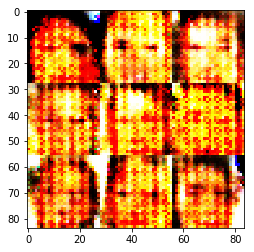

Epoch 1/1... Step 510... Discriminator Loss: 1.3013... Generator Loss: 0.9676
Epoch 1/1... Step 520... Discriminator Loss: 1.3074... Generator Loss: 0.8105
Epoch 1/1... Step 530... Discriminator Loss: 1.4540... Generator Loss: 0.6752
Epoch 1/1... Step 540... Discriminator Loss: 1.6437... Generator Loss: 1.8257
Epoch 1/1... Step 550... Discriminator Loss: 1.6494... Generator Loss: 0.5292
Epoch 1/1... Step 560... Discriminator Loss: 1.3065... Generator Loss: 0.6979
Epoch 1/1... Step 570... Discriminator Loss: 1.4227... Generator Loss: 0.6925
Epoch 1/1... Step 580... Discriminator Loss: 1.4134... Generator Loss: 0.6833
Epoch 1/1... Step 590... Discriminator Loss: 1.2778... Generator Loss: 0.7875
Epoch 1/1... Step 600... Discriminator Loss: 1.6634... Generator Loss: 0.5058
Generating sample outputs


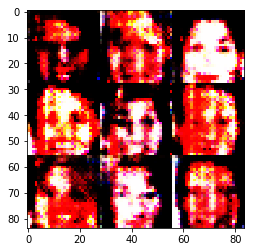

Epoch 1/1... Step 610... Discriminator Loss: 1.4242... Generator Loss: 0.6358
Epoch 1/1... Step 620... Discriminator Loss: 1.4204... Generator Loss: 0.7779
Epoch 1/1... Step 630... Discriminator Loss: 1.3780... Generator Loss: 0.7411
Epoch 1/1... Step 640... Discriminator Loss: 1.3087... Generator Loss: 0.7232
Epoch 1/1... Step 650... Discriminator Loss: 1.3113... Generator Loss: 0.9397
Epoch 1/1... Step 660... Discriminator Loss: 0.9159... Generator Loss: 0.9740
Epoch 1/1... Step 670... Discriminator Loss: 0.8384... Generator Loss: 1.0046
Epoch 1/1... Step 680... Discriminator Loss: 0.7306... Generator Loss: 1.7237
Epoch 1/1... Step 690... Discriminator Loss: 1.0825... Generator Loss: 1.1123
Epoch 1/1... Step 700... Discriminator Loss: 0.7838... Generator Loss: 1.6803
Generating sample outputs


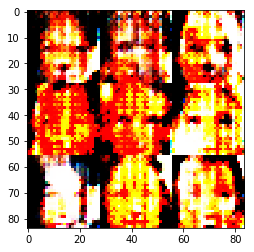

Epoch 1/1... Step 710... Discriminator Loss: 1.2223... Generator Loss: 1.0728
Epoch 1/1... Step 720... Discriminator Loss: 0.8068... Generator Loss: 1.1311
Epoch 1/1... Step 730... Discriminator Loss: 1.2154... Generator Loss: 0.6937
Epoch 1/1... Step 740... Discriminator Loss: 1.4380... Generator Loss: 0.6855
Epoch 1/1... Step 750... Discriminator Loss: 1.3072... Generator Loss: 0.7584
Epoch 1/1... Step 760... Discriminator Loss: 1.3202... Generator Loss: 0.9139
Epoch 1/1... Step 770... Discriminator Loss: 1.3785... Generator Loss: 0.7171
Epoch 1/1... Step 780... Discriminator Loss: 1.3113... Generator Loss: 0.7165
Epoch 1/1... Step 790... Discriminator Loss: 1.5544... Generator Loss: 0.5627
Epoch 1/1... Step 800... Discriminator Loss: 1.4371... Generator Loss: 0.6488
Generating sample outputs


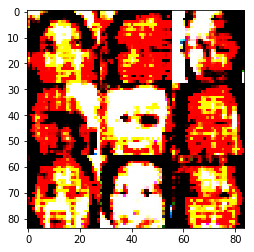

Epoch 1/1... Step 810... Discriminator Loss: 1.3413... Generator Loss: 0.8002
Epoch 1/1... Step 820... Discriminator Loss: 1.3764... Generator Loss: 1.1021
Epoch 1/1... Step 830... Discriminator Loss: 1.2949... Generator Loss: 0.7044
Epoch 1/1... Step 840... Discriminator Loss: 1.2596... Generator Loss: 1.1609
Epoch 1/1... Step 850... Discriminator Loss: 0.9122... Generator Loss: 1.0477
Epoch 1/1... Step 860... Discriminator Loss: 2.4767... Generator Loss: 1.4385
Epoch 1/1... Step 870... Discriminator Loss: 1.3901... Generator Loss: 0.6990
Epoch 1/1... Step 880... Discriminator Loss: 1.3732... Generator Loss: 0.6905
Epoch 1/1... Step 890... Discriminator Loss: 1.5097... Generator Loss: 0.7175
Epoch 1/1... Step 900... Discriminator Loss: 1.3239... Generator Loss: 0.7124
Generating sample outputs


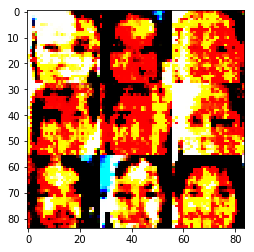

Epoch 1/1... Step 910... Discriminator Loss: 1.4336... Generator Loss: 0.6581
Epoch 1/1... Step 920... Discriminator Loss: 1.3426... Generator Loss: 0.7826
Epoch 1/1... Step 930... Discriminator Loss: 1.3812... Generator Loss: 0.7923
Epoch 1/1... Step 940... Discriminator Loss: 1.3714... Generator Loss: 0.8305
Epoch 1/1... Step 950... Discriminator Loss: 1.3667... Generator Loss: 0.7475
Epoch 1/1... Step 960... Discriminator Loss: 1.3880... Generator Loss: 0.7617
Epoch 1/1... Step 970... Discriminator Loss: 1.3463... Generator Loss: 0.8725
Epoch 1/1... Step 980... Discriminator Loss: 1.3467... Generator Loss: 0.8316
Epoch 1/1... Step 990... Discriminator Loss: 1.4034... Generator Loss: 0.7965
Epoch 1/1... Step 1000... Discriminator Loss: 1.2944... Generator Loss: 0.9409
Generating sample outputs


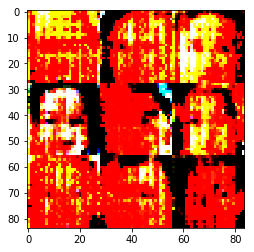

Epoch 1/1... Step 1010... Discriminator Loss: 1.2509... Generator Loss: 0.8103
Epoch 1/1... Step 1020... Discriminator Loss: 1.2742... Generator Loss: 0.8389
Epoch 1/1... Step 1030... Discriminator Loss: 1.3225... Generator Loss: 0.6850
Epoch 1/1... Step 1040... Discriminator Loss: 1.3771... Generator Loss: 0.7362
Epoch 1/1... Step 1050... Discriminator Loss: 1.3336... Generator Loss: 0.8820
Epoch 1/1... Step 1060... Discriminator Loss: 1.3049... Generator Loss: 0.7302
Epoch 1/1... Step 1070... Discriminator Loss: 1.3198... Generator Loss: 0.8202
Epoch 1/1... Step 1080... Discriminator Loss: 1.3756... Generator Loss: 0.9066
Epoch 1/1... Step 1090... Discriminator Loss: 1.2402... Generator Loss: 0.7254
Epoch 1/1... Step 1100... Discriminator Loss: 1.3656... Generator Loss: 0.8117
Generating sample outputs


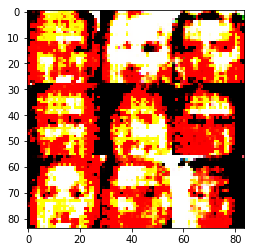

Epoch 1/1... Step 1110... Discriminator Loss: 1.3592... Generator Loss: 0.6933
Epoch 1/1... Step 1120... Discriminator Loss: 1.3971... Generator Loss: 0.7560
Epoch 1/1... Step 1130... Discriminator Loss: 1.3706... Generator Loss: 0.8453
Epoch 1/1... Step 1140... Discriminator Loss: 1.3826... Generator Loss: 0.7466
Epoch 1/1... Step 1150... Discriminator Loss: 1.4082... Generator Loss: 0.6932
Epoch 1/1... Step 1160... Discriminator Loss: 1.4061... Generator Loss: 0.7517
Epoch 1/1... Step 1170... Discriminator Loss: 1.5243... Generator Loss: 0.6033
Epoch 1/1... Step 1180... Discriminator Loss: 1.3459... Generator Loss: 0.8073
Epoch 1/1... Step 1190... Discriminator Loss: 1.3429... Generator Loss: 0.8141
Epoch 1/1... Step 1200... Discriminator Loss: 1.3906... Generator Loss: 0.8040
Generating sample outputs


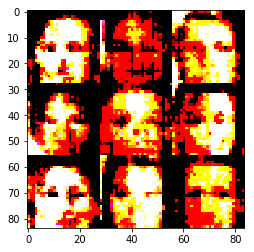

Epoch 1/1... Step 1210... Discriminator Loss: 1.3905... Generator Loss: 0.7524
Epoch 1/1... Step 1220... Discriminator Loss: 1.3883... Generator Loss: 0.8529
Epoch 1/1... Step 1230... Discriminator Loss: 1.3378... Generator Loss: 0.8580
Epoch 1/1... Step 1240... Discriminator Loss: 1.3711... Generator Loss: 0.7824
Epoch 1/1... Step 1250... Discriminator Loss: 1.3146... Generator Loss: 0.7763
Epoch 1/1... Step 1260... Discriminator Loss: 1.4250... Generator Loss: 0.7519
Epoch 1/1... Step 1270... Discriminator Loss: 1.2822... Generator Loss: 0.7244
Epoch 1/1... Step 1280... Discriminator Loss: 1.3856... Generator Loss: 1.1318
Epoch 1/1... Step 1290... Discriminator Loss: 1.3265... Generator Loss: 0.5669
Epoch 1/1... Step 1300... Discriminator Loss: 1.3912... Generator Loss: 0.9904
Generating sample outputs


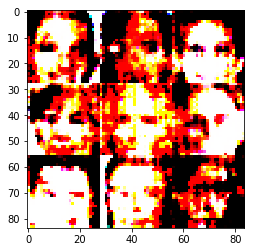

Epoch 1/1... Step 1310... Discriminator Loss: 1.2836... Generator Loss: 0.7389
Epoch 1/1... Step 1320... Discriminator Loss: 1.3616... Generator Loss: 0.7690
Epoch 1/1... Step 1330... Discriminator Loss: 1.3391... Generator Loss: 0.8678
Epoch 1/1... Step 1340... Discriminator Loss: 1.5592... Generator Loss: 0.6008
Epoch 1/1... Step 1350... Discriminator Loss: 1.3689... Generator Loss: 0.7618
Epoch 1/1... Step 1360... Discriminator Loss: 1.3405... Generator Loss: 0.7543
Epoch 1/1... Step 1370... Discriminator Loss: 1.3783... Generator Loss: 0.7905
Epoch 1/1... Step 1380... Discriminator Loss: 1.3346... Generator Loss: 0.9322
Epoch 1/1... Step 1390... Discriminator Loss: 1.2234... Generator Loss: 0.7844
Epoch 1/1... Step 1400... Discriminator Loss: 1.3533... Generator Loss: 0.8059
Generating sample outputs


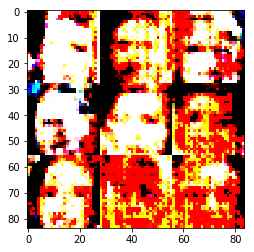

Epoch 1/1... Step 1410... Discriminator Loss: 1.4155... Generator Loss: 0.7458
Epoch 1/1... Step 1420... Discriminator Loss: 1.3491... Generator Loss: 0.8057
Epoch 1/1... Step 1430... Discriminator Loss: 1.2476... Generator Loss: 0.7481
Epoch 1/1... Step 1440... Discriminator Loss: 1.3846... Generator Loss: 0.7693
Epoch 1/1... Step 1450... Discriminator Loss: 1.3913... Generator Loss: 0.7496
Epoch 1/1... Step 1460... Discriminator Loss: 1.4289... Generator Loss: 0.8069
Epoch 1/1... Step 1470... Discriminator Loss: 1.4054... Generator Loss: 0.5604
Epoch 1/1... Step 1480... Discriminator Loss: 1.3955... Generator Loss: 0.7287
Epoch 1/1... Step 1490... Discriminator Loss: 1.3075... Generator Loss: 0.8735
Epoch 1/1... Step 1500... Discriminator Loss: 1.3356... Generator Loss: 0.5607
Generating sample outputs


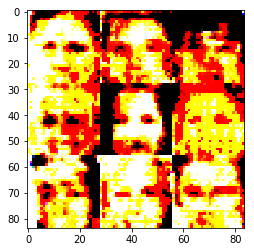

Epoch 1/1... Step 1510... Discriminator Loss: 1.4559... Generator Loss: 0.6468
Epoch 1/1... Step 1520... Discriminator Loss: 1.3635... Generator Loss: 0.7940
Epoch 1/1... Step 1530... Discriminator Loss: 1.3666... Generator Loss: 0.7961
Epoch 1/1... Step 1540... Discriminator Loss: 1.4112... Generator Loss: 0.7639
Epoch 1/1... Step 1550... Discriminator Loss: 1.3693... Generator Loss: 0.8045
Epoch 1/1... Step 1560... Discriminator Loss: 1.3981... Generator Loss: 0.7067
Epoch 1/1... Step 1570... Discriminator Loss: 1.3632... Generator Loss: 0.8597
Epoch 1/1... Step 1580... Discriminator Loss: 1.3973... Generator Loss: 0.7817
Epoch 1/1... Step 1590... Discriminator Loss: 1.4105... Generator Loss: 0.8353
Epoch 1/1... Step 1600... Discriminator Loss: 1.3972... Generator Loss: 0.7904
Generating sample outputs


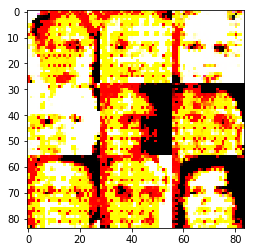

Epoch 1/1... Step 1610... Discriminator Loss: 1.3659... Generator Loss: 0.7542
Epoch 1/1... Step 1620... Discriminator Loss: 1.4194... Generator Loss: 0.7907
Epoch 1/1... Step 1630... Discriminator Loss: 1.3894... Generator Loss: 0.6893
Epoch 1/1... Step 1640... Discriminator Loss: 1.3758... Generator Loss: 0.7316
Epoch 1/1... Step 1650... Discriminator Loss: 1.3618... Generator Loss: 0.8272
Epoch 1/1... Step 1660... Discriminator Loss: 1.3414... Generator Loss: 0.7369
Epoch 1/1... Step 1670... Discriminator Loss: 1.3549... Generator Loss: 0.8291
Epoch 1/1... Step 1680... Discriminator Loss: 1.3681... Generator Loss: 0.8721
Epoch 1/1... Step 1690... Discriminator Loss: 1.3402... Generator Loss: 0.8656
Epoch 1/1... Step 1700... Discriminator Loss: 1.4018... Generator Loss: 0.7994
Generating sample outputs


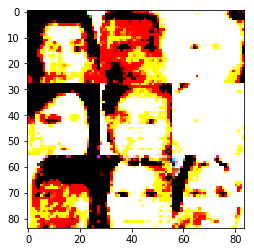

Epoch 1/1... Step 1710... Discriminator Loss: 1.3857... Generator Loss: 0.7274
Epoch 1/1... Step 1720... Discriminator Loss: 1.3606... Generator Loss: 0.7739
Epoch 1/1... Step 1730... Discriminator Loss: 1.3809... Generator Loss: 0.8039
Epoch 1/1... Step 1740... Discriminator Loss: 1.4157... Generator Loss: 0.9530
Epoch 1/1... Step 1750... Discriminator Loss: 1.4680... Generator Loss: 0.6423
Epoch 1/1... Step 1760... Discriminator Loss: 1.3966... Generator Loss: 0.8151
Epoch 1/1... Step 1770... Discriminator Loss: 1.3613... Generator Loss: 0.7305
Epoch 1/1... Step 1780... Discriminator Loss: 1.2412... Generator Loss: 0.7939
Epoch 1/1... Step 1790... Discriminator Loss: 1.3647... Generator Loss: 0.7805
Epoch 1/1... Step 1800... Discriminator Loss: 1.3698... Generator Loss: 0.8075
Generating sample outputs


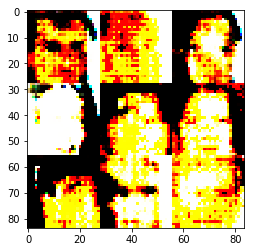

Epoch 1/1... Step 1810... Discriminator Loss: 1.3611... Generator Loss: 0.7812
Epoch 1/1... Step 1820... Discriminator Loss: 1.3651... Generator Loss: 0.8923
Epoch 1/1... Step 1830... Discriminator Loss: 1.3817... Generator Loss: 0.8008
Epoch 1/1... Step 1840... Discriminator Loss: 1.3465... Generator Loss: 0.8006
Epoch 1/1... Step 1850... Discriminator Loss: 1.3380... Generator Loss: 0.7489
Epoch 1/1... Step 1860... Discriminator Loss: 1.3372... Generator Loss: 0.7498
Epoch 1/1... Step 1870... Discriminator Loss: 1.3087... Generator Loss: 0.7623
Epoch 1/1... Step 1880... Discriminator Loss: 1.4150... Generator Loss: 0.7900
Epoch 1/1... Step 1890... Discriminator Loss: 1.3348... Generator Loss: 0.7650
Epoch 1/1... Step 1900... Discriminator Loss: 1.3467... Generator Loss: 0.8274
Generating sample outputs


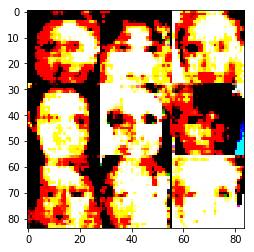

Epoch 1/1... Step 1910... Discriminator Loss: 1.2992... Generator Loss: 0.8819
Epoch 1/1... Step 1920... Discriminator Loss: 1.3238... Generator Loss: 0.8141
Epoch 1/1... Step 1930... Discriminator Loss: 1.4850... Generator Loss: 0.8086
Epoch 1/1... Step 1940... Discriminator Loss: 1.3246... Generator Loss: 0.7593
Epoch 1/1... Step 1950... Discriminator Loss: 1.3441... Generator Loss: 0.7099
Epoch 1/1... Step 1960... Discriminator Loss: 1.3994... Generator Loss: 0.7343
Epoch 1/1... Step 1970... Discriminator Loss: 1.4056... Generator Loss: 0.7119
Epoch 1/1... Step 1980... Discriminator Loss: 1.3460... Generator Loss: 0.8900
Epoch 1/1... Step 1990... Discriminator Loss: 1.4932... Generator Loss: 0.8238
Epoch 1/1... Step 2000... Discriminator Loss: 1.3822... Generator Loss: 0.7625
Generating sample outputs


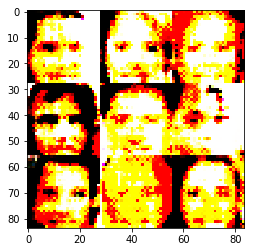

Epoch 1/1... Step 2010... Discriminator Loss: 1.3594... Generator Loss: 0.8076
Epoch 1/1... Step 2020... Discriminator Loss: 1.3966... Generator Loss: 0.8266
Epoch 1/1... Step 2030... Discriminator Loss: 1.3847... Generator Loss: 0.8460
Epoch 1/1... Step 2040... Discriminator Loss: 1.3495... Generator Loss: 0.7370
Epoch 1/1... Step 2050... Discriminator Loss: 1.4232... Generator Loss: 1.0147
Epoch 1/1... Step 2060... Discriminator Loss: 1.3370... Generator Loss: 0.7890
Epoch 1/1... Step 2070... Discriminator Loss: 1.4378... Generator Loss: 0.6781
Epoch 1/1... Step 2080... Discriminator Loss: 1.3765... Generator Loss: 0.7972
Epoch 1/1... Step 2090... Discriminator Loss: 1.3483... Generator Loss: 0.8047
Epoch 1/1... Step 2100... Discriminator Loss: 1.4097... Generator Loss: 0.6638
Generating sample outputs


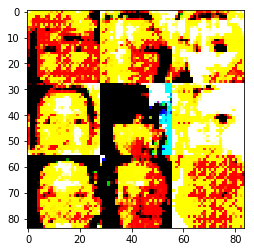

Epoch 1/1... Step 2110... Discriminator Loss: 1.3737... Generator Loss: 0.7452
Epoch 1/1... Step 2120... Discriminator Loss: 1.3757... Generator Loss: 0.7589
Epoch 1/1... Step 2130... Discriminator Loss: 1.5311... Generator Loss: 0.4429
Epoch 1/1... Step 2140... Discriminator Loss: 1.3684... Generator Loss: 0.8147
Epoch 1/1... Step 2150... Discriminator Loss: 1.4136... Generator Loss: 0.5531
Epoch 1/1... Step 2160... Discriminator Loss: 1.3756... Generator Loss: 0.9075
Epoch 1/1... Step 2170... Discriminator Loss: 1.3333... Generator Loss: 0.7997
Epoch 1/1... Step 2180... Discriminator Loss: 1.4366... Generator Loss: 0.6925
Epoch 1/1... Step 2190... Discriminator Loss: 1.4519... Generator Loss: 0.6181
Epoch 1/1... Step 2200... Discriminator Loss: 1.3967... Generator Loss: 0.7662
Generating sample outputs


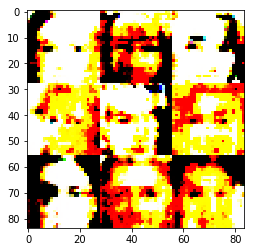

Epoch 1/1... Step 2210... Discriminator Loss: 1.3854... Generator Loss: 0.7318
Epoch 1/1... Step 2220... Discriminator Loss: 1.3979... Generator Loss: 0.8034
Epoch 1/1... Step 2230... Discriminator Loss: 1.4454... Generator Loss: 0.7561
Epoch 1/1... Step 2240... Discriminator Loss: 1.3577... Generator Loss: 0.7626
Epoch 1/1... Step 2250... Discriminator Loss: 1.3560... Generator Loss: 0.6923
Epoch 1/1... Step 2260... Discriminator Loss: 1.4290... Generator Loss: 0.8206
Epoch 1/1... Step 2270... Discriminator Loss: 1.3800... Generator Loss: 0.7455
Epoch 1/1... Step 2280... Discriminator Loss: 1.4627... Generator Loss: 0.6538


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.